### Capstone Project - The Battle of the Neighborhoods

### -----Contents-----

1. Introduction: Business Problem
2. Data
3. Metholodology
4. Analysis
5. Results and Discussion
6. Conclusion

### 1.Introduction: Business Problem

A classmate of mine, who has immigrated with his family from Japan to America and want to open a Japanese Restaurant in New York City. He is only a small-business owner, so the best choice of him is to invest a small Restaurant in New York. We know hat there are a large number of Asia style restaurant in New York City, including korean, chinese, japanese, tailandese restaurants. So he want to know weather it is possible to open a japanese restaurant in New York City or not?

As a data scientist, I can help him to solve this problem and give some advise. Firstly, we need to know how many restaurants are in New York City, especially the number of the japanese restaurants in each Borough and neighbourhood. Secondly, the location, the ratings and tips of these restaurants are what we are interested.

*Buisiness Problem:*
Try to provide as much as more information of the Japanese restaurants in New York City so that my classmate could make a decision whether he can open a new Japanese restaurant or not?

### 2.Data

Accordding to this problem, some below data will be needed :
1. the geographical information of New York City: New York City data that contains list Boroughs, Neighborhoods along with their latitude and longitude. the Data source is available here: https://cocl.us/new_york_dataset
2. Chinese restaurants and distribution in each neighborhood of NYC. We are going to use Foursquare API to get this data.
3. GeoSpace Data of venues in New York City. We can obtain these data from website: https://data.cityofnewyork.us/City-Government/Borough-Boundaries/tqmj-j8zm

#### Data Collection

In [1]:
#import all the necessary packages.
import pandas as pd
import numpy as np
import requests
import os

import json

!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library
from geopy.geocoders import Nominatim 
 # convert an address into latitude and longitude values
# Matplotlib and associated plotting modules
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib as mpl
import matplotlib.patches as patches
%matplotlib inline

print('Libraries imported.')

Solving environment: done

## Package Plan ##

  environment location: /opt/conda/envs/Python36

  added / updated specs: 
    - folium=0.5.0


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    branca-0.3.1               |             py_0          25 KB  conda-forge
    altair-3.2.0               |           py36_0         770 KB  conda-forge
    certifi-2019.6.16          |           py36_1         149 KB  conda-forge
    folium-0.5.0               |             py_0          45 KB  conda-forge
    openssl-1.1.1c             |       h516909a_0         2.1 MB  conda-forge
    ca-certificates-2019.6.16  |       hecc5488_0         145 KB  conda-forge
    vincent-0.4.4              |             py_1          28 KB  conda-forge
    ------------------------------------------------------------
                                           Total:         3.3 MB

The following NEW packages will be 

In [2]:
CLIENT_ID = 'HVXFPY1JQVGOSHMB0QZXYAVXFPP2XQTU5YF3BB2FCP2XCSOI' # your Foursquare ID
CLIENT_SECRET = 'O5VAGB4U5D0NWECO5SZAPQAFWUNQLYUC4HVCCJQPEJOGJO15' # your Foursquare Secret
VERSION = '20180604'
#LIMIT = 10000
print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: HVXFPY1JQVGOSHMB0QZXYAVXFPP2XQTU5YF3BB2FCP2XCSOI
CLIENT_SECRET:O5VAGB4U5D0NWECO5SZAPQAFWUNQLYUC4HVCCJQPEJOGJO15


In [3]:
address = 'New York,NY'

geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Toronto City are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Toronto City are 40.7127281, -74.0060152.


##### Download the data from internet

In [4]:
!wget -q -O 'newyork_data.json' https://cocl.us/new_york_dataset
print('Data downloaded!')

Data downloaded!


In [5]:
with open('newyork_data.json') as json_data:
    newyork_data = json.load(json_data)

In [6]:
neighborhoods_data = newyork_data['features']

##### Transform the data to dataframe

In [7]:
# define the dataframe columns
column_names = ['Borough', 'Neighborhood', 'Latitude', 'Longitude'] 

# instantiate the dataframe
NY_neighborhoods = pd.DataFrame(columns=column_names)

In [9]:
for data in neighborhoods_data:
    borough = neighborhood_name = data['properties']['borough'] 
    neighborhood_name = data['properties']['name']
        
    neighborhood_latlon = data['geometry']['coordinates']
    neighborhood_lat = neighborhood_latlon[1]
    neighborhood_lon = neighborhood_latlon[0]
    
    NY_neighborhoods = NY_neighborhoods.append({'Borough': borough,
                                          'Neighborhood': neighborhood_name,
                                          'Latitude': neighborhood_lat,
                                          'Longitude': neighborhood_lon}, ignore_index=True)

In [10]:
NY_neighborhoods.head(10)

,Borough,Neighborhood,Latitude,Longitude
0,Bronx,Wakefield,40.894705,-73.847201
1,Bronx,Co-op City,40.874294,-73.829939
2,Bronx,Eastchester,40.887556,-73.827806
3,Bronx,Fieldston,40.895437,-73.905643
4,Bronx,Riverdale,40.890834,-73.912585
5,Bronx,Kingsbridge,40.881687,-73.902818
6,Manhattan,Marble Hill,40.876551,-73.910660
7,Bronx,Woodlawn,40.898273,-73.867315
8,Bronx,Norwood,40.877224,-73.879391
9,Bronx,Williamsbridge,40.881039,-73.857446


In [11]:
NY_neighborhoods.shape

(306, 4)

##### Plot the number of neighbourhoods for each borough in NYC

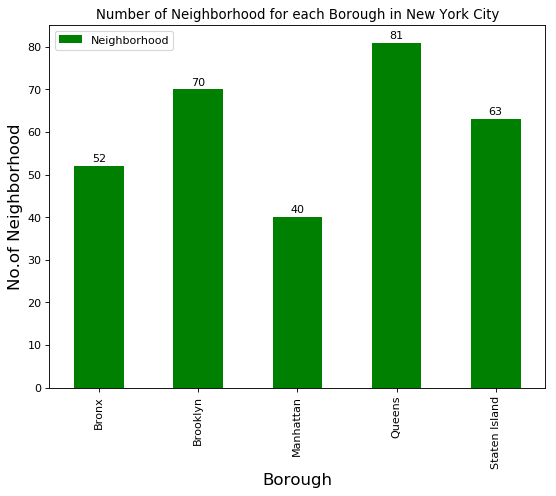

In [12]:
plt.figure(figsize=(8,6), dpi = 80)

# title
plt.title('Number of Neighborhood for each Borough in New York City')
#On x-axis
plt.xlabel('Borough', fontsize = 15)
#On y-axis
plt.ylabel('No.of Neighborhood', fontsize=15)
#giving a bar plot
NY_neighborhoods.groupby('Borough')['Neighborhood'].count().plot(kind='bar',color='green')
#legend
plt.legend()
#show the number of each bar
for x,y in enumerate(NY_neighborhoods.groupby('Borough')['Neighborhood'].count()):
    plt.text(x,y+1,'%s' %round(y,1),ha='center')
#displays the plot
plt.show()

In [13]:
def get_venues(lat,lng):
    
    #set variables
    radius=1000
    LIMIT=10000
    
    #url to fetch data from foursquare api
    url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
    
    # get all the data
    results = requests.get(url).json()
    venue_data=results["response"]['groups'][0]['items']
    venue_details=[]
    for row in venue_data:
        try:
            venue_id=row['venue']['id']
            venue_name=row['venue']['name']
            venue_category=row['venue']['categories'][0]['name']
            venue_details.append([venue_id,venue_name,venue_category])
        except KeyError:
            pass
        
    column_names=['ID','Name','Category']
    df = pd.DataFrame(venue_details,columns=column_names)
    return df

In [14]:
def get_venue_details(venue_id):
    
    #url to fetch data from foursquare api
    url = 'https://api.foursquare.com/v2/venues/{}?&client_id={}&client_secret={}&v={}'.format(
            venue_id,
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION)
    
    # get all the data
    results = requests.get(url).json()
    venue_data=results['response']['venue']
    venue_details=[]
    try:
        venue_id=venue_data['id']
        venue_name=venue_data['name']
        venue_likes=venue_data['likes']['count']
        venue_rating=venue_data['rating']
        venue_tips=venue_data['tips']['count']
        venue_details.append([venue_id,venue_name,venue_likes,venue_rating,venue_tips])
    except KeyError:
        pass
        
    column_names=['ID','Name','Likes','Rating','Tips']
    df = pd.DataFrame(venue_details,columns=column_names)
    return df

In [15]:
column_names=['Borough', 'Neighborhood', 'ID','Name']
japanese_rest_ny=pd.DataFrame(columns=column_names)
count=1
for row in NY_neighborhoods.values.tolist():
    Borough, Neighborhood, Latitude, Longitude=row
    venues = get_venues(Latitude,Longitude)
    japanese_resturants=venues[venues['Category']=='Japanese Restaurant']   
    print('(',count,'/',len(NY_neighborhoods),')','Japanese Resturants in '+Neighborhood+', '+Borough+':'+str(len(japanese_resturants)))
    for resturant_detail in japanese_resturants.values.tolist():
        id, name , category=resturant_detail
        japanese_rest_ny = japanese_rest_ny.append({'Borough': Borough,
                                                'Neighborhood': Neighborhood, 
                                                'ID': id,
                                                'Name' : name
                                               }, ignore_index=True)
    count+=1

( 1 / 306 ) Japanese Resturants in Wakefield, Bronx:0
( 2 / 306 ) Japanese Resturants in Co-op City, Bronx:0
( 3 / 306 ) Japanese Resturants in Eastchester, Bronx:0
( 4 / 306 ) Japanese Resturants in Fieldston, Bronx:0
( 5 / 306 ) Japanese Resturants in Riverdale, Bronx:2
( 6 / 306 ) Japanese Resturants in Kingsbridge, Bronx:2
( 7 / 306 ) Japanese Resturants in Marble Hill, Manhattan:0
( 8 / 306 ) Japanese Resturants in Woodlawn, Bronx:0
( 9 / 306 ) Japanese Resturants in Norwood, Bronx:0
( 10 / 306 ) Japanese Resturants in Williamsbridge, Bronx:0
( 11 / 306 ) Japanese Resturants in Baychester, Bronx:0
( 12 / 306 ) Japanese Resturants in Pelham Parkway, Bronx:0
( 13 / 306 ) Japanese Resturants in City Island, Bronx:1
( 14 / 306 ) Japanese Resturants in Bedford Park, Bronx:0
( 15 / 306 ) Japanese Resturants in University Heights, Bronx:0
( 16 / 306 ) Japanese Resturants in Morris Heights, Bronx:0
( 17 / 306 ) Japanese Resturants in Fordham, Bronx:0
( 18 / 306 ) Japanese Resturants in Ea

In [16]:
japanese_rest_ny

,Borough,Neighborhood,ID,Name
0,Bronx,Riverdale,503cfaffe4b066d39de5005a,Aoyu Japanese Restaurant
1,Bronx,Riverdale,4b0b311af964a520642e23e3,Palace of Japan
2,Bronx,Kingsbridge,503cfaffe4b066d39de5005a,Aoyu Japanese Restaurant
3,Bronx,Kingsbridge,4b0b311af964a520642e23e3,Palace of Japan
4,Bronx,City Island,4dbdf3d790a02849cbd675be,Ohana Japanese Habachi Seafood & Steakhouse
5,Bronx,Spuyten Duyvil,4b0b311af964a520642e23e3,Palace of Japan
6,Bronx,Spuyten Duyvil,503cfaffe4b066d39de5005a,Aoyu Japanese Restaurant
7,Bronx,Castle Hill,54e0efc3498e7eda5dff1847,Sarku
8,Brooklyn,Bay Ridge,4b33fd94f964a520842325e3,Arirang Hibachi Steakhouse
9,Brooklyn,Bay Ridge,4c2678eef1272d7f43a986c5,Fushimi


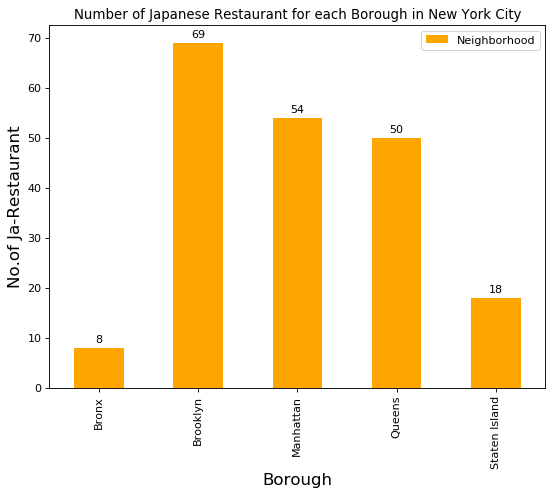

In [21]:
plt.figure(figsize=(8,6), dpi = 80)

# title
plt.title('Number of Japanese Restaurant for each Borough in New York City')
#On x-axis
plt.xlabel('Borough', fontsize = 15)
#On y-axis
plt.ylabel('No.of Ja-Restaurant', fontsize=15)
#giving a bar plot
japanese_rest_ny.groupby('Borough')['Neighborhood'].count().plot(kind='bar',color='orange')
#legend
plt.legend()
#show the number of each bar
for x,y in enumerate(japanese_rest_ny.groupby('Borough')['Neighborhood'].count()):
    plt.text(x,y+1,'%s' %round(y,1),ha='center')
#displays the plot
plt.show()

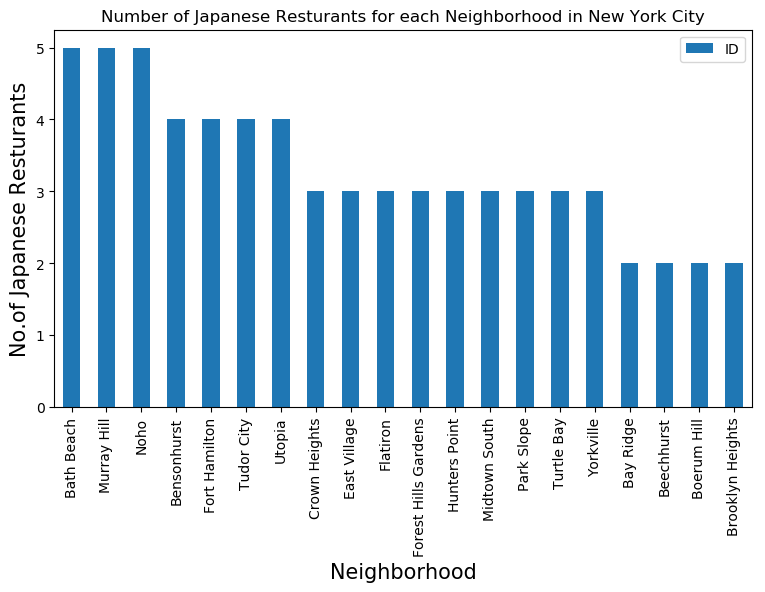

In [24]:
plt.figure(figsize=(9,5), dpi = 100)
# title
plt.title('Number of Japanese Resturants for each Neighborhood in New York City')
#On x-axis
plt.xlabel('Neighborhood', fontsize = 15)
#On y-axis
plt.ylabel('No.of Japanese Resturants', fontsize=15)
#giving a bar plot
japanese_rest_ny.groupby('Neighborhood')['ID'].count().nlargest(20).plot(kind='bar')
#legend
plt.legend()
#displays the plot
plt.show()

In [36]:
japanese_rest_ny.loc[japanese_rest_ny['Neighborhood'].isin(['Bath Beach','Murray Hill','Noho'])]

,Borough,Neighborhood,ID,Name
39,Brooklyn,Bath Beach,4bad45c9f964a52089403be3,Chikurin
40,Brooklyn,Bath Beach,51f42bb3498e2681264e00a1,Kasumi Sushi & BBQ Restaurant
41,Brooklyn,Bath Beach,513e7ec8e4b07f4fa1b53b3d,Fuki Sushi Japanese Restaurant
42,Brooklyn,Bath Beach,4c326b9fa0ced13ac126156e,Ichi Sushi
43,Brooklyn,Bath Beach,4b787863f964a52080d02ee3,Shiki Japanese Hibachi
80,Manhattan,Murray Hill,4a99b4f4f964a520f62f20e3,Kajitsu
81,Manhattan,Murray Hill,540dc46d498e86f0e5059dd2,Zuma New York
82,Manhattan,Murray Hill,49db8b67f964a520d85e1fe3,Aburiya Kinnosuke
83,Manhattan,Murray Hill,5ad925da2f97ec3e4b17eba2,Nonono
124,Queens,Murray Hill,4bc8eee83740b713fcbe5d65,Northern Sushi
